# structN2V

## Overview 

[structN2V](#references) [1] is a self-supervised denoising method based on [Noise2Void](../../n2v/Noise2Void) [2,3]. 
The method was developped to remove pixel-noises from images, even in the presence of spatial noise correlations.

It retains the same training scheme (i.e. training on noisy images by randomly masking pixels), and differs from Noise2Void 
by the use of an additional mask covering the extent of the spatial noise correlation.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from careamics.transforms.n2v_manipulate import N2VManipulate
from careamics_portfolio import PortfolioManager
from scipy.ndimage import convolve


def autocorrelation(x):
    """
    nD autocorrelation
    remove mean per-patch (not global GT)
    normalize stddev to 1
    value at zero shift normalized to 1...
    """
    x = (x - np.mean(x)) / np.std(x)
    x = np.fft.fftn(x)
    x = np.abs(x) ** 2
    x = np.fft.ifftn(x).real
    x = x / x.flat[0]
    x = np.fft.fftshift(x)
    return x


def get_hcorrelated_noise(shape, noise):
    purenoise = []
    noise_kernel = np.array([[1, 1, 1]]) / 3  ## horizontal correlations

    noise = convolve(noise, noise_kernel)

    purenoise = np.array(noise)
    purenoise = purenoise - purenoise.mean()

    return purenoise


# download file
portfolio = PortfolioManager()
files = portfolio.denoiseg.MouseNuclei_n0.download()
files.sort()

# load data
test_data = np.load(files[0])

## Pixel-wise independent noise

It might happen that the noise in your images is not pixel-wise independent. In this case,
the network can learn the amount of noise in the masked pixels from its neighboring pixels.
Noise2Void might then introduce small artefacts or simply reinforce the correlated 
pattern in the denoised image. 

Correlations in the noise can sometimes be observed with sCMOS camera or point-scanning 
microscopy methods. To estimate whether the noise is correlated, one can perform image 
autocorrelation and inspect the shape of the central peak in the distribution. The next 
figure shows two examples of the same image with artificial Gaussian noise. In the second 
one, we introduced a correlation in the Gaussian noise, leading to an horizontal line in
the autocorrelation image.

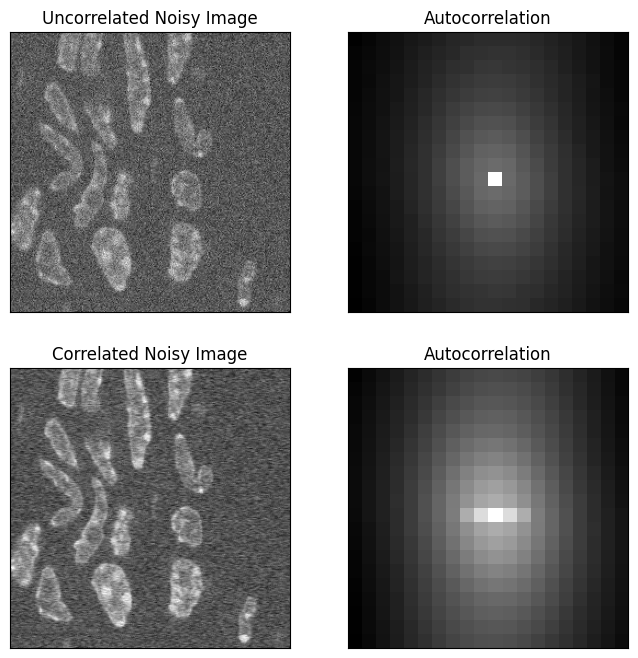

In [6]:
# compute noise and autocorrelation
clean_img = test_data["X_test"][0]
clean_img_autocorr = autocorrelation(clean_img)

# create a noisy image by adding 0 mean gaussian noise
sigma = 50
noisy = np.random.normal(0, sigma, clean_img.shape)
noisy_img = clean_img + noisy
noisy_img_autocorr = autocorrelation(noisy_img)

# add correlated noise
correlated_noise = get_hcorrelated_noise(clean_img.shape, noisy)
correlated_noisy_img = clean_img + correlated_noise
correlated_noisy_img_autocorr = autocorrelation(correlated_noisy_img)

# show images in one column and their correlation in the other
# crop the correlation around (0, 0)
midpoint = clean_img.shape[0] // 2
crop_size = 10
slices = (
    slice(midpoint - crop_size, midpoint + crop_size),
    slice(midpoint - crop_size, midpoint + crop_size),
)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(noisy_img, cmap="gray")
ax[0, 0].set_title("Uncorrelated Noisy Image")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(noisy_img_autocorr[slices], cmap="gray")
ax[0, 1].set_title("Autocorrelation")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[1, 0].imshow(correlated_noisy_img, cmap="gray")
ax[1, 0].set_title("Correlated Noisy Image")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(correlated_noisy_img_autocorr[slices], cmap="gray")
ax[1, 1].set_title("Autocorrelation")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
plt.show()

*Fig 1.: Structured noise. Top row: image with uncorrelated noise (left) and its 
autocorrelation (close-up on the zero-shift component). Bottom row: same images with
correlations introduced in the noise component. CC-BY.* 

## N2V vs structN2V masking

In order to obfuscate the pixel values whose noise might be correlated, structN2V 
introduces a mask spanning the extent of the correlation. In order to estimate the size
and direction of the correlation, one simply needs to examine the autocorrelation image 
(see section above).

However, as in Noise2Void, masking pixels by setting their values to zero will confuse
the network by introducing unrealistic values. To circumvent this issue, structN2V replaces
the masked pixels by values uniformly sampled between the minimum and maximum pixel values
of the patch.

/var/folders/g8/92r7j4_x0tvg2hn1rl_pd3f40000gp/T/ipykernel_51808/2951486792.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


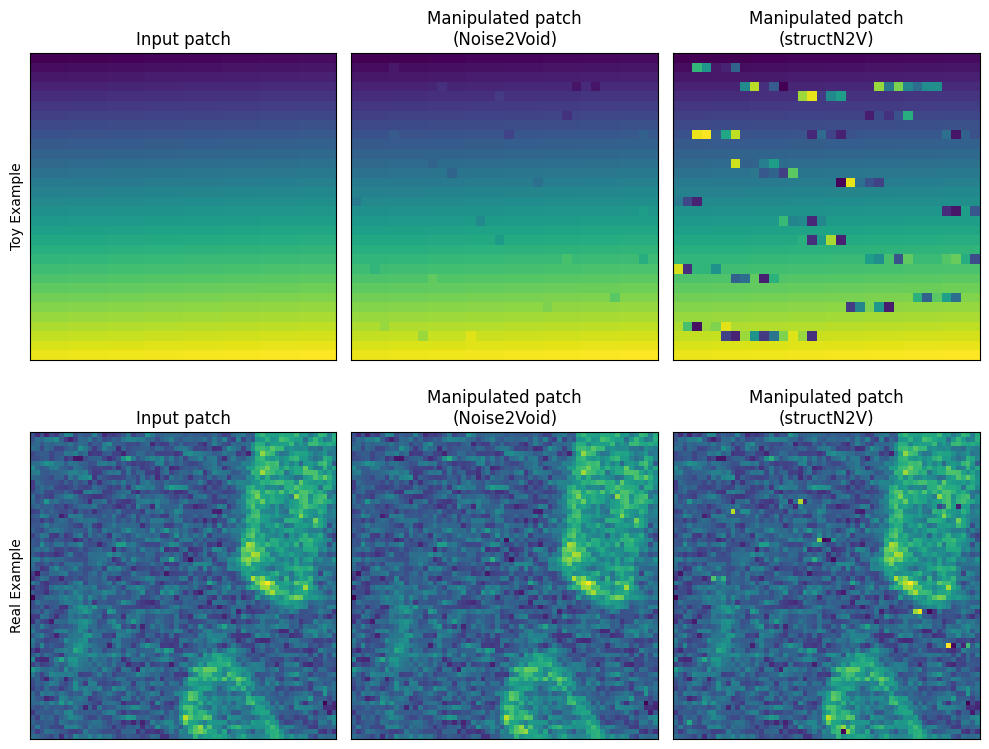

In [12]:
######### toy example
# array
scale = 32
patch = np.arange(scale**2).reshape((1, scale, scale))

# manipulate n2v
manipulate_n2v = N2VManipulate(roi_size=4, masked_pixel_percentage=2, seed=24)
manipulate_structn2v = N2VManipulate(
    roi_size=4,
    masked_pixel_percentage=2,
    struct_mask_axis="horizontal",
    struct_mask_span=5,
    seed=24,
)

# apply n2v manipulation
manipulated, _, mask = manipulate_n2v(patch)

# apply n2v manipulation with median
manipulated_struct, _, mask_struct = manipulate_structn2v(patch)

######### real example
n2v_manipulate_real = N2VManipulate(seed=42)
n2v_manipulate_real_struct = N2VManipulate(
    seed=42,
    struct_mask_axis="horizontal",
    struct_mask_span=5,
)

real_patch = correlated_noisy_img[:64, :64][np.newaxis, ...]
real_noisy = np.random.normal(0, 25, real_patch.shape)
real_noisy = real_patch + real_noisy

real_manipulated, _, real_mask = n2v_manipulate_real(real_noisy)
real_manipulated_struct, _, real_mask_struct = n2v_manipulate_real_struct(real_noisy)

# show manipulated patch next to mask
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
ax[0, 0].imshow(patch.squeeze())
ax[0, 0].set_title("Input patch")
ax[0, 0].set_ylabel("Toy Example")
ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].imshow(manipulated.squeeze())
ax[0, 1].set_title("Manipulated patch\n(Noise2Void)")
ax[0, 1].set_xticks([])
ax[0, 1].set_yticks([])

ax[0, 2].imshow(manipulated_struct.squeeze())
ax[0, 2].set_title("Manipulated patch\n(structN2V)")
ax[0, 2].set_xticks([])
ax[0, 2].set_yticks([])

ax[1, 0].imshow(real_noisy.squeeze())
ax[1, 0].set_title("Input patch")
ax[1, 0].set_ylabel("Real Example")
ax[1, 0].set_xticks([])
ax[1, 0].set_yticks([])

ax[1, 1].imshow(real_manipulated.squeeze())
ax[1, 1].set_title("Manipulated patch\n(Noise2Void)")
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])

ax[1, 2].imshow(real_manipulated_struct.squeeze())
ax[1, 2].set_title("Manipulated patch\n(structN2V)")
ax[1, 2].set_xticks([])
ax[1, 2].set_yticks([])
fig.tight_layout()
fig.show()

*Fig 2.: Noise2Void vs structN2V manipulation, with a toy example (top row) and a 
real-world one (bottom row). In both algorithms, randomly selected pixels
in the input patch (left) are selected and their value replaced. Noise2Void (center) 
replaces the values by the value of one of the neighboring pixel, while structN2V (right) 
additionally masks neighboring pixels using a uniformly sampled value comprised betweem 
the min and max patch value to prevent the network from learning from the
noise correlations. CC-BY.*  

## References

[1] Coleman Broaddus, Alexander Krull, Martin Weigert, Uwe Schmidt, and Gene Myers. "
Removing structured noise with self-supervised blind-spot networks." ISBI, 2020.
[link](https://ieeexplore.ieee.org/abstract/document/9098336)

[2] Alexander Krull, Tim-Oliver Buchholz, and Florian Jug. "Noise2Void - learning denoising
from single noisy images." CVPR, 2019. [link](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html)

[3] Joshua Batson, and Loic Royer. "Noise2Self: Blind denoising by self-supervision." 
MLR, 2019. [link](http://proceedings.mlr.press/v97/batson19a.html)
